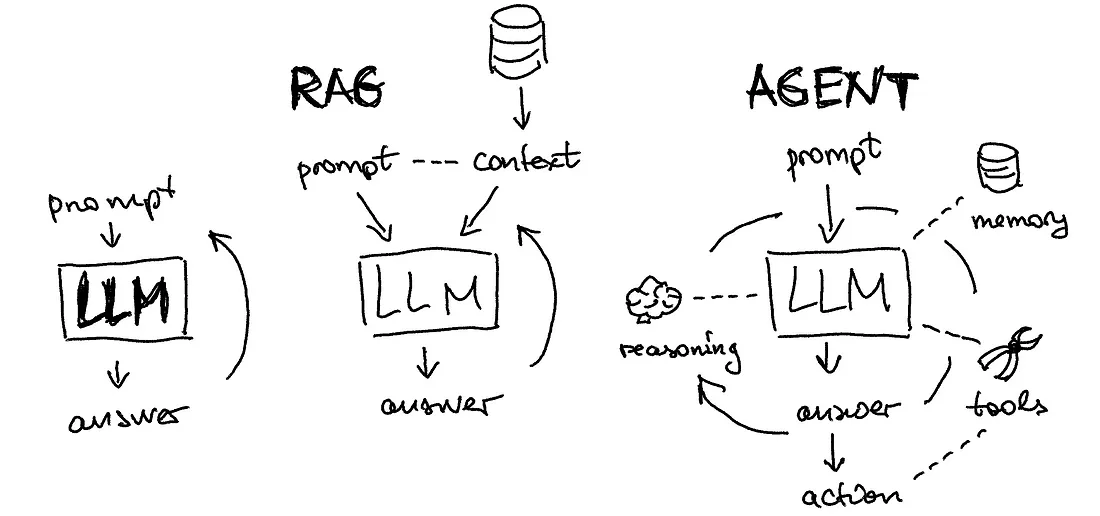

https://towardsdatascience.com/intro-to-llm-agents-with-langchain-when-rag-is-not-enough-7d8c08145834

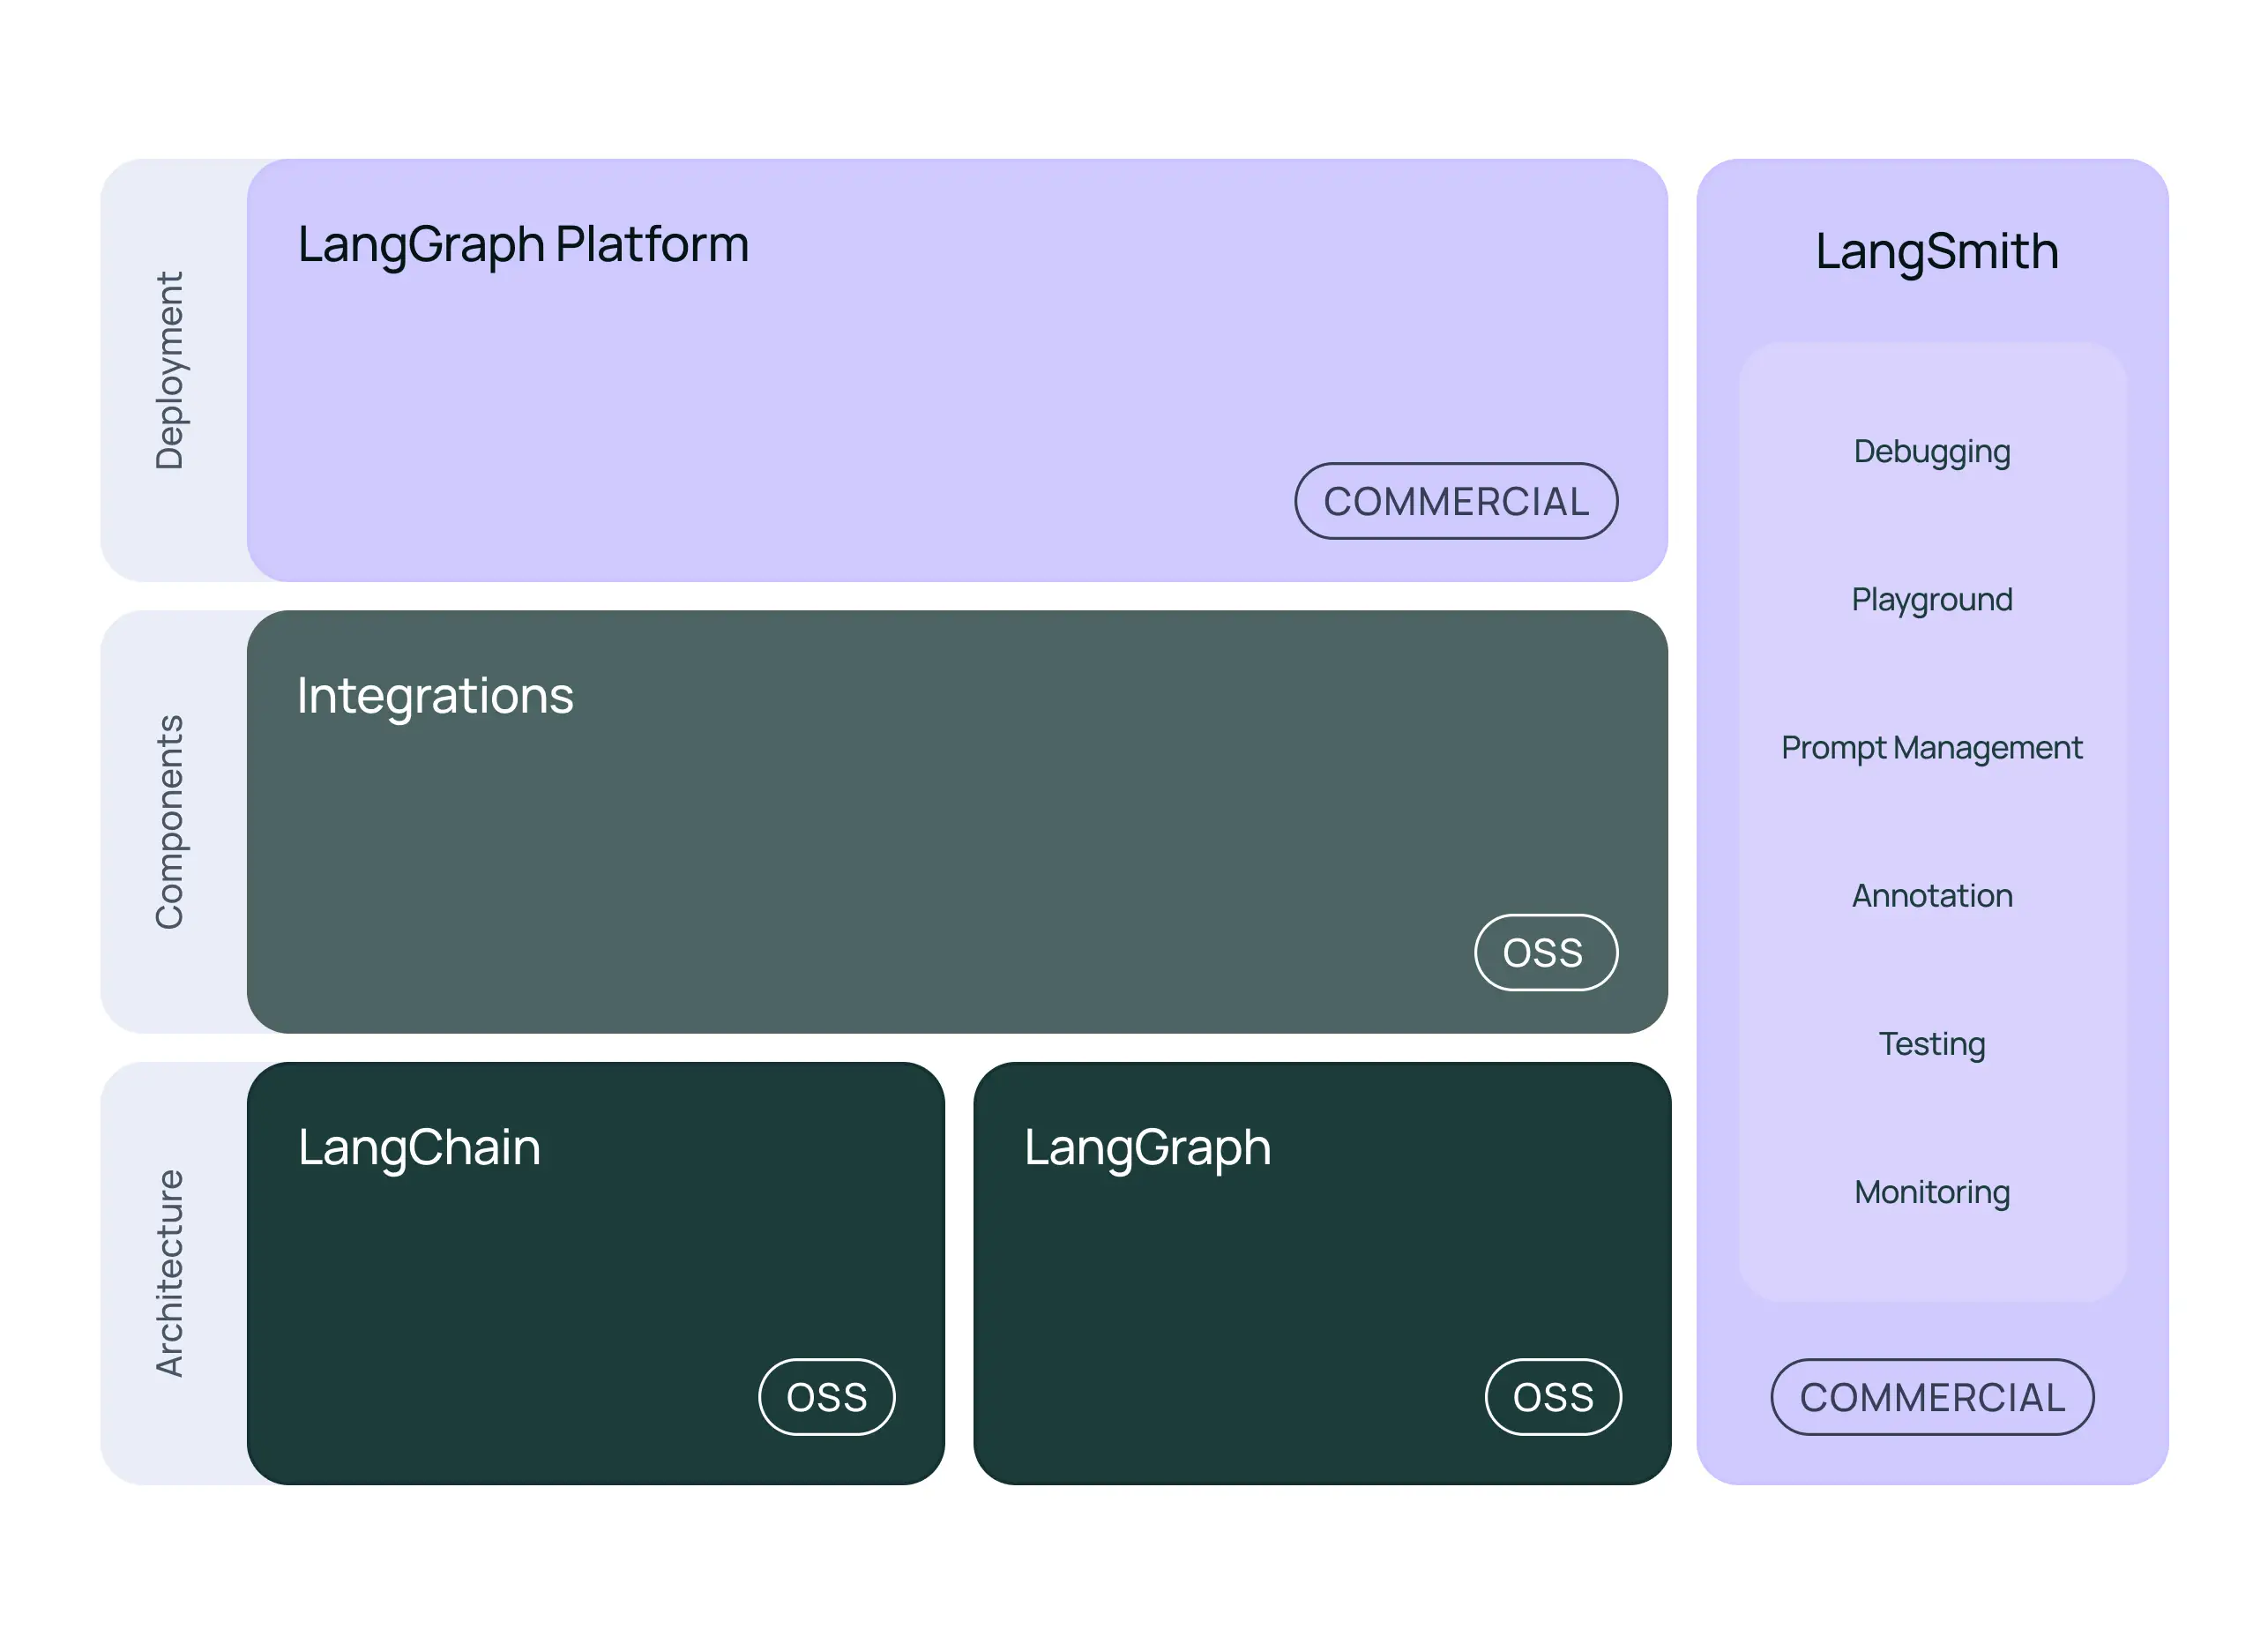

https://www.langchain.com/langchain

In [ ]:
!pip install requests beautifulsoup4 langchain openai
!pip install langchain_community
!pip install langchain-experimental

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.llms import OpenAI
from langchain_experimental.tools import PythonREPLTool
from langchain.memory import ConversationBufferMemory
import requests
from bs4 import BeautifulSoup

In [ ]:

# OpenAI API 키 설정
OPENAI_API_KEY = "OPENAI_API_KEY"
llm = OpenAI(temperature=0, api_key=OPENAI_API_KEY)


In [ ]:

# 1 Python REPL 도구
python_tool = PythonREPLTool()

print(python_tool.run('print([x**2 for x in range(5)])'))

In [ ]:

# 2 웹 크롤링 도구 정의
def web_scraper(query: str) -> str:
    """
    간단한 웹 크롤러: 주어진 쿼리를 구글 검색 결과로 크롤링.
    """
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
    search_url = f"https://www.google.com/search?q={query}"

    response = requests.get(search_url, headers=headers)
    if response.status_code != 200:
        return "크롤링에 실패했습니다. 상태 코드: {}".format(response.status_code)

    soup = BeautifulSoup(response.text, "html.parser")

    # 검색 결과에서 제목과 링크를 가져옴
    results = []
    for g in soup.find_all("div", class_="tF2Cxc"):
        title = g.find("h3").text if g.find("h3") else "제목 없음"
        link = g.find("a")["href"] if g.find("a") else "링크 없음"
        results.append(f"{title} ({link})")

    return "\n".join(results[:5])  # 상위 5개 결과 반환

# 크롤링 도구를 LangChain Tool로 등록
web_scraper_tool = Tool(
    name="Web Scraper",
    func=web_scraper,
    description="입력된 쿼리에 대해 구글 검색 결과를 가져옵니다. (HTML 기반 크롤링)"
)

print(web_scraper_tool.run('한양대 맛집'))

In [ ]:

def naver_scraper(query: str) -> str:
    """
    주어진 쿼리에 대해 네이버 검색 결과를 크롤링하여 상위 5개의 제목과 링크를 반환합니다.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }
    search_url = f"https://search.naver.com/search.naver?ssc=tab.blog.all&sm=tab_jum&query={query}"

    response = requests.get(search_url, headers=headers)
    if response.status_code != 200:
        return f"크롤링에 실패했습니다. 상태 코드: {response.status_code}"

    soup = BeautifulSoup(response.text, "html.parser")

    # 검색 결과에서 제목과 링크를 추출
    results = []
    for item in soup.select(".title_link"):
        title = item.get_text(strip=True)
        link = item.get('href', '링크 없음')
        results.append(f"{title} ({link})")

    return "\n".join(results[:5])  # 상위 5개 결과 반환


# 크롤링 도구를 LangChain Tool로 등록
naver_scraper_tool = Tool(
    name="Naver Scraper",
    func=naver_scraper,
    description="입력된 쿼리에 대해 네이버 검색 결과를 가져옵니다. (HTML 기반 크롤링)"
)

print(naver_scraper_tool.run('한양대 맛집'))


In [ ]:

# Memory 설정
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# LangChain Agent 초기화
agent = initialize_agent(
    tools=[python_tool, web_scraper_tool, naver_scraper_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    memory=memory,
    verbose=True
)

# 에이전트 실행
print("LangChain Agent 실행. 'exit' 입력 시 종료됩니다.")
while True:
    user_input = input("User: ")
    if user_input.lower() == "exit":
        print("에이전트를 종료합니다.")
        break
    response = agent.run(user_input)
    print(f"Agent: {response}")